In [1]:
from pathlib import Path
import pandas as pd
import logging
import time
import random
import json
import sys
import pickle

sys.path.append("../")
from scores_1kv import *

# One extra .. compared
PATH_JSON  = Path.cwd() / "../../1kv_json"
PATH_ONCHAIN = Path.cwd() / "../../onchain"
PATH_NEWFIGS = Path.cwd() / "../../new_figs"
PATH_INFO = Path.cwd() / "../../info"
PATH_TMP = Path.cwd() / "../../tmp"

In [2]:
# Load files  
df_1kv = pd.read_feather(PATH_TMP / "kusama" / "df_1kv.feather")
df_era_reward_onchain = pd.read_feather(PATH_TMP / "kusama" / "df_era_reward_onchain.feather")
stash_1kv = pickle.load(open(PATH_TMP / "kusama" / "stash_1kv.p", "rb"))
start_era_onchain = read_onchain_era_start_file(PATH_ONCHAIN / "kusama" / "on_chain_era_start.feather")
last_1kv = pd.read_feather(PATH_INFO / "kusama" / "last_info_1kv.feather")    


In [3]:
# The score for location is based on the frequency of that location. 
# We thus first count them and these counts are in the quantile calculation.
# The table last_location is nice to have (and to put on the website) 
# but we also want to put the theoretical score in the original dataframe.
# For that, we will replace the location name with the count & score.
last_location = pd.DataFrame()
tmp = last_1kv[["stash", "location"]].copy()
tmp = tmp.replace('', '(empty)')
last_location["count"] = tmp["location"].value_counts()
last_location["score"] = round(calc_inclusion_scores(last_location["count"], LOW_Q=0.1, UPP_Q=0.95, SCORE_WEIGHT=score_weights["location"]),2)
last_location = last_location.reset_index().rename(columns={"index": "location"})
loc_to_count = dict(zip(last_location["location"], last_location["count"]))
loc_to_score = dict(zip(last_location["location"], last_location["score"]))
last_1kv["location.count"] = last_1kv["location"].replace(loc_to_count)
last_1kv["th-score.location"] = last_1kv["location"].replace(loc_to_score)
last_1kv[["th-score.location", "score.location"]]

,th-score.location,score.location
0,3.64,7.512690
1,0.00,0.000000
2,14.55,14.545455
3,40.00,40.000000
4,36.36,36.363636
...,...,...
503,0.00,3.398693
504,36.36,40.000000
505,36.36,34.771242
506,36.36,34.771242


In [4]:
loc_to_count = dict(zip(last_location["location"], last_location["count"]))
loc_to_score = dict(zip(last_location["location"], last_location["score"]))
last_1kv["location.count"] = last_1kv["location"].replace(loc_to_count)
last_1kv["th-score.location"] = last_1kv["location"].replace(loc_to_score)
# last_1kv["th-score.location"] = last_location["score"]
last_1kv[["location", "location.count", "th-score.location", "score.location"]]

,location,location.count,th-score.location,score.location
0,Amsterdam,11,3.64,7.512690
1,Frankfurt am Main,21,0.00,0.000000
2,Berlin,8,14.55,14.545455
3,Darmstadt,1,40.00,40.000000
4,Sofia,2,36.36,36.363636
...,...,...,...,...
503,Düsseldorf,13,0.00,3.398693
504,Miami,2,36.36,40.000000
505,Kaunas,2,36.36,34.771242
506,Los Angeles,2,36.36,34.771242


In [15]:
tmp = last_1kv[["stash", "location", "location.count", "th-score.location", "score.location"]].copy()
tmp["error"] = last_1kv["th-score.location"] - last_1kv["score.location"]
tmp = tmp.sort_values("error")
tmp
# store datetime of latest json dump date (only fair to compare to that), store also era (make function that gets era from datetime)



,stash,location,location.count,th-score.location,score.location,error
447,Dq97kmsJXGTciU1eMXZMAp4D41Y9e7kQ4hmFBfZW7YD4CCf,Falkenstein,11,3.64,19.084967,-15.444967
291,FyRaMYvPqpNGq6PFGCcUWcJJWKgEz29ZFbdsnoNAczC2wJZ,Falkenstein,11,3.64,19.084967,-15.444967
394,EA9YDzksfSR3RjM5TzKS7bdvEzi7bycXLK15o5g6XTFxFfW,Falkenstein,11,3.64,19.084967,-15.444967
489,CsKvJ4fdesaRALc5swo5iknFDpop7YUwKPJHdmUvBsUcMGb,Falkenstein,11,3.64,19.084967,-15.444967
367,EDNEfKXHd645DPpBhLZjaEwp4sPhj4STjjS4QrMbFU1FqbZ,Falkenstein,11,3.64,19.084967,-15.444967
...,...,...,...,...,...,...
44,EjLP52pfZTXAoh35GV1KapLjwpFV1uLBLVsswVJuAxkXoyi,Gravelines,4,29.09,13.333333,15.756667
47,HHWm4YjgJjKv8xrCokUshUKhGfsdbBmjoNV6aGWVgAznZEr,Gunzenhausen,4,29.09,12.413793,16.676207
25,GXihX81hjYw4f5VQd9s1zsLU1poyo6hGqfPtcx2GJDVyyYx,Kirkland,1,40.00,20.000000,20.000000
8,GxuEngysAC4a5SZX9w7eTVY4iye8RRxVVXbzfSxXzJ8Nf3Y,Groningen,3,32.73,4.000000,28.730000


(array([0.0503937 , 0.01062992, 0.00866142, 0.00314961, 0.04055118,
        0.01811024, 0.01338583, 0.00905512, 0.00866142, 0.03740157]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

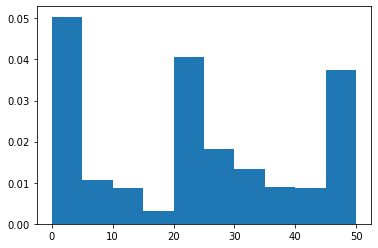

In [14]:
plt.hist(last_1kv["score.bonded"], density=True)

In [17]:
start_era_onchain

,start,datetime
era,,
4254,1664299674020,2022-09-27 17:27:54.020
4257,1664364474023,2022-09-28 11:27:54.023
4261,1664450874022,2022-09-29 11:27:54.022
4264,1664515674015,2022-09-30 05:27:54.015
4266,1664558874017,2022-09-30 17:27:54.017
4272,1664688474016,2022-10-02 05:27:54.016
4274,1664731674013,2022-10-02 17:27:54.013
4276,1664774874014,2022-10-03 05:27:54.014
4280,1664861274014,2022-10-04 05:27:54.014


In [190]:
fields = ["stash", "name", "datetime", "rank", "faults", "commission", "valid", "location"] + list(descr_scores.keys())
last_1kv = df_1kv[fields].dropna()
last_1kv = last_1kv.sort_values('datetime').drop_duplicates(["stash"], keep='last').reset_index(drop=True)
last_1kv.to_json(PATH_INFO / "kusama" / "last_info_1kv.json")
last_1kv.to_feather(PATH_INFO / "kusama" / "last_info_1kv.feather")
last_1kv

,stash,name,datetime,rank,faults,commission,valid,location,score.inclusion,score.spanInclusion,...,score.democracy,score.councilStake,score.aggregate,score.randomness,score.total,score.nominatorStake,score.delegations,score.region,score.country,score.provider
0,FCes7ZDr12Xa3CgfjsZdR2vKRKqNM5fDYbn6TszjgX8KMmd,Paramito-KV1,2022-09-07 09:54:22.361999872,192,0,3.0,True,Amsterdam,0.000000,0.000000,...,100.000000,50.0,212.010303,1.102672,233.777860,37.317316,0.0,16.923077,29.795918,40.000000
1,Cd2ewfXdQiaUzTBYKSZTzL7hPuB3nzEKMT2y36zJC9QaEG4,Fennel Validator 0,2022-09-15 07:17:22.731000064,390,0,5.0,False,Frankfurt am Main,100.000000,100.000000,...,0.000000,0.0,278.192798,1.000430,278.312372,9.969430,0.0,0.000000,0.000000,27.096774
2,G7xzXN3ddsqcsPswNKRhroyptEsh1oakjQ98K7fRZUTUvkr,Jormungand_Labs,2022-09-15 07:19:33.054000128,395,5,3.0,False,Berlin,0.000000,28.571429,...,6.659939,50.0,165.999230,1.092501,181.354272,50.000000,0.0,27.387387,0.000000,0.000000
3,GHWU4uLy8noYVgKD1UoxHEQ9NvHg64R4jYsCp1nSq5iDgbJ,Bartalamew,2022-09-15 07:21:09.724000000,308,2,3.0,False,Darmstadt,0.000000,28.571429,...,6.029263,50.0,191.830297,1.044618,200.389296,50.000000,0.0,0.000000,0.000000,0.000000
4,Fv2j2uTAQE6jmKzRq6rzbkrVyMvq1TYZsm9AhoQoXo6uhWw,d0tk0s-1-sv-validator-0,2022-09-15 07:24:33.243000064,44,22,0.0,False,Sofia,100.000000,100.000000,...,0.000000,12.5,312.598098,1.130499,353.391967,0.000000,0.0,38.198198,39.393939,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,G1AX3QgZyjAaNpMgTgnyY9uDgJAzezv84bxHZLgHevmpkVZ,al3c5,2022-10-26 07:37:09.900000000,184,0,10.0,True,Bezannes,0.000000,38.888889,...,89.786314,50.0,244.736789,1.039102,254.306450,3.580828,0.0,9.924812,8.666667,0.000000
516,EK2yYS2xW96AGZaCn21Xcwdp5xzQVAe6VmoSpSYLg7ZvmmV,Aurora,2022-10-26 07:37:22.849999872,249,0,15.0,True,Austin,24.859813,93.333333,...,100.000000,50.0,412.978061,1.119123,462.173433,5.827871,0.0,29.974937,4.666667,33.548387
517,GNYcq54aXW3PuZ6mJnNzuV9AfYrJhL7HJ5svCEzn1XTuov8,lunar_dot_2,2022-10-26 07:37:52.215000064,253,0,10.0,True,Amsterdam,0.000000,31.111111,...,100.000000,50.0,280.946508,1.132285,318.111633,5.926534,0.0,13.934837,28.666667,0.000000
518,J7XHBQxacqTTVkoNoSgcG6CgREb9JVh2DHBbBQ1ycvkLBq4,WEB3-SPACE | N01,2022-10-26 07:38:19.051000064,113,2,9.0,True,Ingolstadt,61.495327,46.666667,...,0.000000,50.0,257.829128,1.034615,266.753806,5.765725,0.0,0.000000,0.000000,0.000000


In [191]:
addr = "FPc6HXzVyCbsarcyLEN6UnHbhWxdUputwEe5saQxmMUj63X"
tmp = last_1kv[last_1kv["stash"]==addr]
scores_used = ['score.inclusion',
 'score.spanInclusion',
 'score.discovered',
 'score.nominated',
 'score.rank',
 'score.bonded',
 'score.faults',
 'score.offline',
 'score.location',
 'score.democracy',
 'score.councilStake',
 'score.nominatorStake',
 'score.delegations',
 'score.region',
 'score.country',
 'score.provider']
tot = 0
for s in scores_used:
    tot += tmp[s]
print(f"total computed = {tot}")
print(f"total aggre = {tmp['score.aggregate']}")

total computed = 242    620.027213
Name: score.inclusion, dtype: float64
total aggre = 242    620.027213
Name: score.aggregate, dtype: float64


In [111]:
# https://github.com/w3f/1k-validators-be/blob/1ff144c96c7105d102a8206e982dea3a8f405615/packages/common/src/constraints.ts
# // Scale the location value to between the 10th and 95th percentile
#       const scaledLocation =
#         scaledDefined(candidateLocation, locationValues, 0.1, 0.95) || 0;
#       const locationScore = (1 - scaledLocation) * this.LOCATION_WEIGHT || 0;
last_location = pd.DataFrame()
tmp = last_1kv[["stash", "location"]].copy()
tmp = tmp.replace('', '(empty)')
last_location["count"] = tmp["location"].value_counts()
last_location["score"] = round(calc_inclusion_scores(last_location["count"], LOW_Q=0.1, UPP_Q=0.95, SCORE_WEIGHT=score_weights["location"]),2)
last_location = last_location.reset_index().rename(columns={"index": "location"})
last_location.to_csv(PATH_INFO / "kusama" / "last_location.csv")




In [52]:
last_score = last_1kv[["name", "stash", "rank", "score.total"]].copy()
last_score["score"] = round(last_score["score.total"],2)
last_score = last_score.drop(columns={"score.total"})
last_score = last_score.sort_values('score', ascending=False)
last_score = last_score.reset_index(drop=True)
last_score.to_csv(PATH_INFO / "kusama" / "last_score.csv")
last_score

,name,stash,rank,score
0,⛰ HELIKON ⛰ ISTANBUL,GC8fuEZG4E5epGf5KGXtcDfvrc6HXE7GJ5YnbiqSpqdQYLg,366,606.45
1,Good Karma,JKbJoCsgUEgjbGmGq7VdSNgSVQt8k43e3WWAYGCpiNP9r6D,327,583.33
2,TX1,EtuN1h92gaV961S15PwxN6GHyeonaojALZ8Dddgn1oDPRFt,163,582.35
3,vertex,GMdKDQYpi6j2px524iP2yGvd9GHDdwuZr3HyBnBFmygeboj,128,579.45
4,freedom,EQF1HnQhSHRqfFEc5aReFHpKZDwkDP8F1WACQ1nN7TGopeV,234,579.32
...,...,...,...,...
559,SynerWork Inc #2,FMBvL5eqMoCzoR5Rd3p4WKhSbzQGEkpMDBvY1jr431PGa4s,49,76.40
560,King Kusama,EDHmmQtv8jGf3PGrsSJC2Bm2YWsF6DWTdKyTtBifPRHQTna,40,74.05
561,0Yakuza [ 1 ],GM8b9ZjQ8yGWavLRfL7hcu2MxuDSKCZaQDp1jPhL1zdTGXr,22,71.27
562,SynerWork Inc,F7hDMvu33u14QPXbkBzqF4CuuyyruB2xi6D3V7aUbY8KGpr,119,58.05


In [3]:
stash_1kv = pickle.load(open(PATH_TMP / "kusama" / "stash_1kv.p", "rb"))
scores_1kv_era = pickle.load(open(PATH_TMP / "kusama" / "scores_1kv_era.p", "rb"))
scores_1kv_era_update = pickle.load(open(PATH_TMP / "kusama" / "scores_1kv_era_update.p", "rb"))

In [4]:
stash_1kv

array(['J6HxQniipCQLVAJxzC1pn2DphoN3za9eAq1bhkBtMhZ9sid',
       'GhNL9Mi5KiL3Ge2jv4jUdncipZNnUFALbzmwg8QqwjxJxcp',
       'GC8fuEZG4E5epGf5KGXtcDfvrc6HXE7GJ5YnbiqSpqdQYLg',
       'GCporqtiw7ybKYUqAftjvUAjZnp3x9gfrWsTy1GrvrGwmYT',
       'GD6MTUJG9Ym7tS6PLF42yreHpqpvFgPcqPwcyRGiMv2TSGR',
       'GM31KcErdS3ob8wmFSbLycccJ6YGvvTXLBAawd6d9wkAxqj',
       'H1LZZkqyYFv28bjP3HcGM5RdAEoCGFEuA8tHdfLGwwGw73t',
       'FFRsm3haD645qfSVE1zfywYURWQ6z7YUAD4nad6Zw6qVxDk',
       'FqFKeVrWbBDVBk8U9VvL8gSFwUm4nj9fEZmtQvmViZzLvnv',
       'HngUT2inDFPBwiey6ZdqhhnmPKHkXayRpWw9rFj55reAqvi',
       'Fs72xecWY6SRwKNH2voodiSsdVKeath4kofHEGsZGLibSxh',
       'F8H3cT1XKWHbkWSRhyVbRgpqn1nLhXGCL1uUdXQJmavpACQ',
       'JJiV1xrj1814BVDDG2pFCsgzdbR7K29VcyXQGXEUhn7LWhK',
       'HcdBFbGDMFzs5MuYQxFQpTBivHgH1UyFKqQDip9YgmqngKH',
       'FVwmuHZRbnEBrA6ya4SYAGt9ChtZWqqjgF2H758mAcHMhuW',
       'CaoTugdjFQ86Bg6sC8CiJyeNPiU8U1ZVLTXhheyENrjApqh',
       'G2JyVQGxihdKXDBCC6BYNvsrY9NT4CsxfJ9dF1kjsyX2PJv',
       'GyrcqN

In [60]:
save_dir = PATH_NEWFIGS / "kusama"
for a in stash_1kv[0:10]:
    make_figs_all_scores(scores_1kv_era, scores_1kv_era_update, descr_scores, bound_scores, a, save_dir)

In [65]:
for i in range(100):
    a = scores_1kv_era["score.location"].loc["J6HxQniipCQLVAJxzC1pn2DphoN3za9eAq1bhkBtMhZ9sid"].index.values

In [70]:
scores_1kv_era.keys()

dict_keys(['score.inclusion', 'score.spanInclusion', 'score.discovered', 'score.nominated', 'score.bonded', 'score.democracy', 'score.location'])

In [102]:
df_1kv = read_1kv_json(PATH_JSON / "kusama")
stash_1kv = df_1kv.stash.unique()

df_stash = df_1kv[["stash"]].drop_duplicates().reset_index(drop=True)
    
start_era_onchain = read_onchain_era_start_file(PATH_ONCHAIN / "kusama" / "on_chain_era_start.feather")

# Select only 1kv validators
df_era_reward_onchain = read_onchain_erareward_files(PATH_ONCHAIN / "kusama" / "all" ).query("address in @stash_1kv")
# turn into wide for easier visual
era_reward_onchain = df_era_reward_onchain.pivot(index="address", columns="era", values="points").replace(np.nan, 0)

# Calculate time stamps of eras so we can compare with data reported by 1kv json
DURATION_EPOCH = pd.to_timedelta("6 hours")
eras = era_reward_onchain.columns.values
# take earliest known era (is 0 since sorted)
known_era = start_era_onchain.index[0]
known_time = start_era_onchain.iloc[0]["datetime"]
eras_start = known_time + (eras  - known_era)*DURATION_EPOCH

eras = pd.DataFrame({"era": eras, "start": eras_start}).reset_index(drop=True)      
eras["end"] = eras["start"] + DURATION_EPOCH - pd.to_timedelta("1 ms")
df_eras_start_end = eras.copy()


# check errors
intersect = start_era_onchain[["datetime"]].join(eras[["era","start"]].set_index("era"), how="inner")
intersect["diff"] = intersect["datetime"] - intersect["start"]
# intersect["diff_sec"] = intersect["diff"].apply(pd.Timedelta.total_seconds)
avg_err = intersect["diff"].abs().mean().total_seconds()

descr_scores = {
    "score.inclusion": "Inclusion score: In active set over 84 eras", 
    "score.spanInclusion": "Span inclusion score: In active set over 28 eras",
    "score.discovered": "Discovered score: When joined the 1kv program",
    "score.nominated": "Nominated score: Last time nominated by 1kv",
    "score.bonded": "Bonded score: Amount of self-bonded",
    "score.democracy": "Democracy score: Consistency in voting at referenda",
    "score.location": "Location score: Location shared by other validators"
    }
# From constraints.tx    -> new: https://github.com/w3f/1k-validators-be/blob/master/packages/gateway/config/main.sample.json
score_tmp =  {
"inclusion": "140",
"spanInclusion": "140",
"discovered": "5",
"nominated": "30",
"rank": "5",
"bonded": "50",
"faults": "5",
"offline": "2",
"location": "40",
"region": "10",
"country": "10",
"provider": "50",
"council": "50",
"democracy": "100",
"nominations": "100",
"delegations": "60"
}
score_weights = {key: int(value) for (key, value) in score_tmp.items()}
bound_scores = {f"score.{key}": np.array([0., value]) for (key, value) in score_weights.items()}


scores_1kv_era = {}
scores_1kv_era_update = {}
for score in descr_scores.keys():
    scores_1kv_era[score], scores_1kv_era_update[score] = align_score_1kv_to_era(df_1kv, score, df_eras_start_end, stash_1kv)

Number of rows: 83218
Number of rows: 84213
Number of rows: 85909
Number of rows: 116777
Number of rows: 128909
Number of rows: 136798
Number of rows: 139814
Number of rows: 141430
Number of rows: 147801
Number of rows: 149259
Number of rows: 151754
Number of rows: 155133
Number of rows: 159701
Number of rows: 183566
Number of rows: 189280


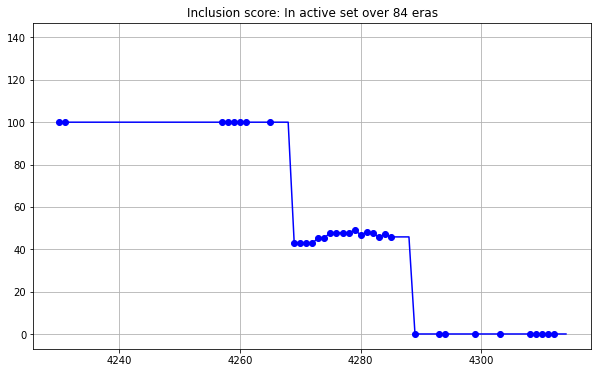

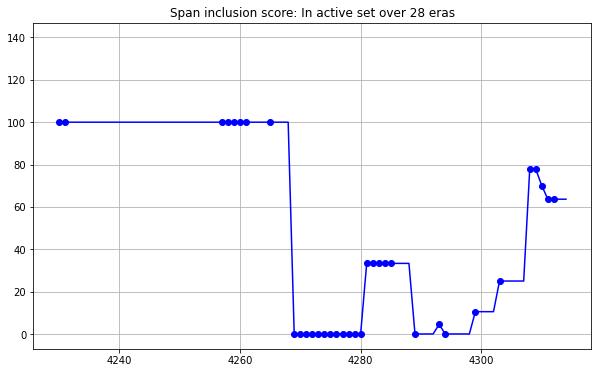

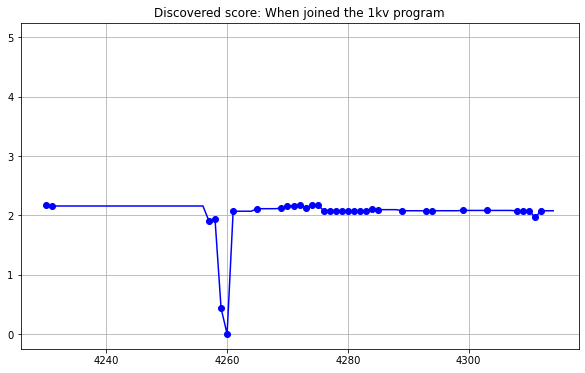

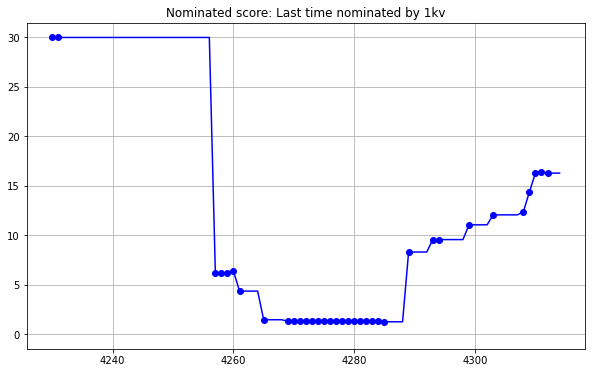

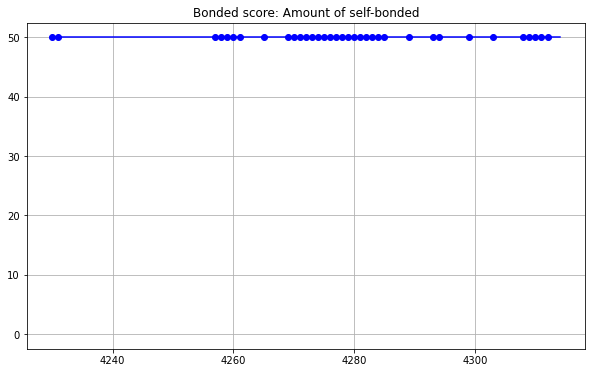

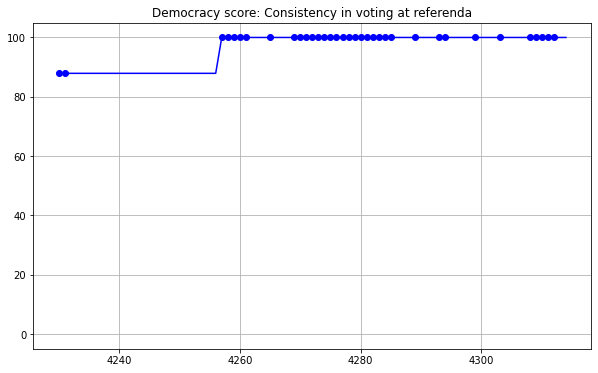

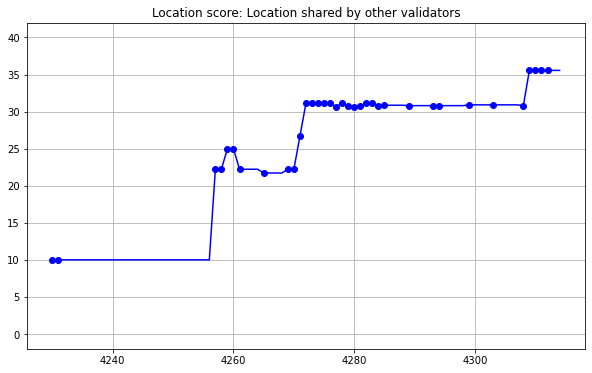

In [108]:
make_figs_all_scores(scores_1kv_era, scores_1kv_era_update, descr_scores, bound_scores, stash_1kv[0])

In [112]:
save_dir = PATH_NEWFIGS / "kusama"
for addr in stash_1kv[0:1]:    
    make_figs_all_scores(scores_1kv_era, scores_1kv_era_update, descr_scores, bound_scores, addr, save_dir)


In [10]:
df_1kv.columns

Index(['discoveredAt', 'nominatedAt', 'offlineSince', 'offlineAccumulated',
       'rank', 'faults', 'invalidityReasons', 'unclaimedEras', 'inclusion',
       'name', 'stash', 'kusamaStash', 'commission', 'active', 'valid',
       'validity', 'total', 'location', 'councilStake', 'councilVotes',
       'democracyVoteCount', 'democracyVotes', 'identity.name', 'identity.sub',
       'identity.verified', 'identity._id', 'score._id', 'score.updated',
       'score.address', 'score.total', 'score.aggregate',
       'score.spanInclusion', 'score.inclusion', 'score.discovered',
       'score.nominated', 'score.rank', 'score.unclaimed', 'score.bonded',
       'score.faults', 'score.offline', 'score.location', 'score.region',
       'score.country', 'score.asn', 'score.provider', 'score.councilStake',
       'score.democracy', 'score.nominatorStake', 'score.delegations',
       'score.randomness', 'score.__v', 'score', 'datetime'],
      dtype='object')

In [14]:
df_1kv[["stash", "name", "commission", "valid"]].drop_duplicates()

,stash,name,commission,valid
0,J6HxQniipCQLVAJxzC1pn2DphoN3za9eAq1bhkBtMhZ9sid,🍀LuckyFriday-KSM-07🍀,15.0,True
1,GhNL9Mi5KiL3Ge2jv4jUdncipZNnUFALbzmwg8QqwjxJxcp,NeNa,10.0,True
2,GC8fuEZG4E5epGf5KGXtcDfvrc6HXE7GJ5YnbiqSpqdQYLg,⛰ HELIKON ⛰ ISTANBUL,3.0,True
3,GCporqtiw7ybKYUqAftjvUAjZnp3x9gfrWsTy1GrvrGwmYT,bolinas-201,5.0,True
4,GD6MTUJG9Ym7tS6PLF42yreHpqpvFgPcqPwcyRGiMv2TSGR,Zetetic Validator,15.0,True
...,...,...,...,...
371672,DNDBcYD8zzqAoZEtgNzouVp2sVxsvqzD4UdB5WrAUwjqpL8,Simply Staking,10.0,False
371798,GLJLgrKhPDzSvNCNjQ184si3Fvu3bzSJBzewkzEZRVLV2oe,Simply Staking 2,10.0,False
386697,HvumdQbk47PXTz57UDrZP5n8rmgf27upC1ooPjtZf9XA2Wk,XUAN_LOW_COMMISSION_NODE,15.0,False
399895,EpeeGt1x3kju8TZmfcaHTkBwTn7eyq4Sxy8Z3dPU88chMcN,CertHum-MaxStake-sv-validator-0,0.0,False


In [52]:
df_stash = df_1kv[["stash"]].drop_duplicates().reset_index(drop=True)
df_stash.to_feather(PATH_INFO / "kusama" / "stash_1kv.feather")
df_stash.to_json(PATH_INFO / "kusama" / "stash_1kv.json")

In [94]:
score =  {
    "inclusion": "140",
    "spanInclusion": "140",
    "discovered": "5",
    "nominated": "30",
    "rank": "5",
    "bonded": "50",
    "faults": "5",
    "offline": "2",
    "location": "40",
    "region": "10",
    "country": "10",
    "provider": "50",
    "council": "50",
    "democracy": "100",
    "nominations": "100",
    "delegations": "60"
    }

In [80]:
df_1kv["score.c"].sort_values(ascending=False)

197777    30.0
147886    30.0
570724    30.0
14662     30.0
431330    30.0
          ... 
596044     NaN
596590     NaN
596591     NaN
596592     NaN
596593     NaN
Name: score.rank, Length: 596594, dtype: float64

In [101]:
score_weights = {key: int(value) for (key, value) in score.items()}
t = {f"score.{key}": np.array([0., value]) for (key, value) in score_weights.items()}
t

{'score.inclusion': array([  0., 140.]),
 'score.spanInclusion': array([  0., 140.]),
 'score.discovered': array([0., 5.]),
 'score.nominated': array([ 0., 30.]),
 'score.rank': array([0., 5.]),
 'score.bonded': array([ 0., 50.]),
 'score.faults': array([0., 5.]),
 'score.offline': array([0., 2.]),
 'score.location': array([ 0., 40.]),
 'score.region': array([ 0., 10.]),
 'score.country': array([ 0., 10.]),
 'score.provider': array([ 0., 50.]),
 'score.council': array([ 0., 50.]),
 'score.democracy': array([  0., 100.]),
 'score.nominations': array([  0., 100.]),
 'score.delegations': array([ 0., 60.])}

In [74]:
tmp = df_1kv[["stash", "name", "commission", "valid"]].drop_duplicates().set_index("stash")
df_dupl = tmp.loc[tmp.index.duplicated(False)]
df_dupl = df_dupl[~df_dupl["valid"].isnull()]
df_dupl

,name,commission,valid
stash,,,
J6HxQniipCQLVAJxzC1pn2DphoN3za9eAq1bhkBtMhZ9sid,🍀LuckyFriday-KSM-07🍀,15.0,True
GhNL9Mi5KiL3Ge2jv4jUdncipZNnUFALbzmwg8QqwjxJxcp,NeNa,10.0,True
GC8fuEZG4E5epGf5KGXtcDfvrc6HXE7GJ5YnbiqSpqdQYLg,⛰ HELIKON ⛰ ISTANBUL,3.0,True
GCporqtiw7ybKYUqAftjvUAjZnp3x9gfrWsTy1GrvrGwmYT,bolinas-201,5.0,True
GD6MTUJG9Ym7tS6PLF42yreHpqpvFgPcqPwcyRGiMv2TSGR,Zetetic Validator,15.0,True
...,...,...,...
DNDBcYD8zzqAoZEtgNzouVp2sVxsvqzD4UdB5WrAUwjqpL8,Simply Staking,10.0,False
GLJLgrKhPDzSvNCNjQ184si3Fvu3bzSJBzewkzEZRVLV2oe,Simply Staking 2,10.0,False
HvumdQbk47PXTz57UDrZP5n8rmgf27upC1ooPjtZf9XA2Wk,XUAN_LOW_COMMISSION_NODE,15.0,False


In [89]:
df_dupl = df_dupl.sort_values("valid")
df_dupl[~df_dupl.duplicated(["name", "valid"])]
# df_dupl[df_dupl["name"].duplicated()]

,name,commission,valid
stash,,,
DzmvnHyHyPN2kBHYQpXmrrUvV8KNzDgTPE2Ri2cjDuXhhLt,OnFinalityV#2,10.0,False
GEx1pz4oGTdNh2mTX8Vrgvfhb2SoA6PoiMqjEfv14nydqot,NewOmegaValidator,0.0,False
GTUi6r2LEsf71zEQDnBvBvKskQcWvK66KRqcRbdmcczaadr,🥩 Staking4All 🥩,3.0,False
FyRaMYvPqpNGq6PFGCcUWcJJWKgEz29ZFbdsnoNAczC2wJZ,🔱-Masternode24-🔱,0.0,False
EfcQCKZJaNu2vcrpnJDCoh1ub4mGWcHVzeU8ghUH7Co9rui,Stakely,5.0,False
...,...,...,...
GC8fuEZG4E5epGf5KGXtcDfvrc6HXE7GJ5YnbiqSpqdQYLg,⛰ HELIKON ⛰ ISTANBUL,3.0,True
GxxV8DAcHCSzBbspu83AK9UoTYxzSQ6VVfdopjnkXfPtE8d,ryabinav1,3.0,True
DPc3YPyWts9LjqBUy7hhLDwN4iHPXU6vicURDMYAMqnW5gi,Genesis Lab /2,7.0,True


In [51]:
df_1kv[~(df_1kv["name"]=="Mile-Charlie")]

,discoveredAt,nominatedAt,offlineSince,offlineAccumulated,rank,faults,invalidityReasons,unclaimedEras,inclusion,name,...,score.asn,score.provider,score.councilStake,score.democracy,score.nominatorStake,score.delegations,score.randomness,score.__v,score,datetime
0,1631223190241,1663890300150,0,0,189,1,,[],0.000000,🍀LuckyFriday-KSM-07🍀,...,37.590361,37.674419,50.0,100.000000,2.097982,0.0,1.115778,0.0,NaN,2022-09-29 01:53:25.888999936
1,1591659416547,1664163841500,0,0,604,0,,[],0.130952,NeNa,...,34.132029,34.444444,50.0,91.922571,39.938401,0.0,1.096741,0.0,NaN,2022-09-29 02:32:02.880999936
2,1612302005541,1663814249983,0,0,359,1,,[],0.178571,⛰ HELIKON ⛰ ISTANBUL,...,37.269625,37.402597,50.0,100.000000,21.097566,0.0,1.071256,0.0,NaN,2022-09-29 01:53:22.560999936
3,1607714020874,1663824287273,0,0,342,0,,[],0.107143,bolinas-201,...,6.748166,8.518519,50.0,88.325965,7.905648,0.0,1.125289,0.0,NaN,2022-09-29 02:36:34.312000000
4,1611074931972,1663880400190,0,0,367,0,,[],0.178571,Zetetic Validator,...,23.617747,24.415584,50.0,91.402792,1.747091,0.0,1.073559,0.0,NaN,2022-09-29 01:52:57.428999936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458437,1660083661754,0,0,0,0,0,,[],0.000000,anvel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
458438,1663401838455,0,0,0,0,0,,[],0.000000,WolfEdge-Labs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
458439,1664262999295,0,0,0,0,0,,[],0.000000,STAKEMORE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
458441,1664757178299,0,0,0,0,0,,[],0.000000,Leostake,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [29]:
df_stash

,stash
0,J6HxQniipCQLVAJxzC1pn2DphoN3za9eAq1bhkBtMhZ9sid
1,GhNL9Mi5KiL3Ge2jv4jUdncipZNnUFALbzmwg8QqwjxJxcp
2,GC8fuEZG4E5epGf5KGXtcDfvrc6HXE7GJ5YnbiqSpqdQYLg
3,GCporqtiw7ybKYUqAftjvUAjZnp3x9gfrWsTy1GrvrGwmYT
4,GD6MTUJG9Ym7tS6PLF42yreHpqpvFgPcqPwcyRGiMv2TSGR
...,...
561,HMat4V87JEtRKMthyMKMX8yMpGPkzjiy1dZBVQ7RDQCQkFt
562,Gvtpyq5SFo7bcjA287yCqN7UqrpdBS7vYcMbyzaTKBDmUmc
563,F7otXz5RLDMf1Vcdo98zY4zYWQ13E7yeST48ZRS9QKHdr3d
564,HNGMhUpVnZjuJ3kQcBAMF4KVywdkk2SCxQ4TAt6QBKtMCFh


In [120]:
descr_scores = {
        "score.inclusion": "Inclusion: Active for last 84 eras", 
        "score.spanInclusion": "Span inclusion: Active for last 28 eras",
        "score.discovered": "Discovered: Join date in 1kv",
        "score.nominated": "Nominated: Last time nominated by 1kv",
        "score.rank": "Rank: Rank in 1kv",        
        "score.bonded": "Bonded: Amount of self bond",
        "score.faults": "Faults: Number of on chain faults",
        "score.offline": "Offline: Offline during this week", 
        "score.location": "Location: Location shared by other validators",
        "score.democracy": "Democracy: Consistency in voting at referenda",
        "score.councilStake": "Council stake: ...",
        }



In [121]:
for v in list(descr_scores.keys()):
    key = f"${v.split('.')[-1]}$"
    print(key)

$inclusion$
$spanInclusion$
$discovered$
$nominated$
$rank$
$bonded$
$faults$
$offline$
$location$
$democracy$
$councilStake$


In [126]:
subs = {f"${v.split('.')[-1]}$" : v  for v in list(descr_scores.keys())}

{'$inclusion$': 'score.inclusion',
 '$spanInclusion$': 'score.spanInclusion',
 '$discovered$': 'score.discovered',
 '$nominated$': 'score.nominated',
 '$rank$': 'score.rank',
 '$bonded$': 'score.bonded',
 '$faults$': 'score.faults',
 '$offline$': 'score.offline',
 '$location$': 'score.location',
 '$democracy$': 'score.democracy',
 '$councilStake$': 'score.councilStake'}

In [129]:
last_1kv = pd.read_feather(PATH_INFO / "kusama" / "last_info_1kv.feather")
last_1kv.columns

Index(['stash', 'name', 'datetime', 'rank', 'faults', 'commission', 'valid',
       'score.total', 'location'],
      dtype='object')

In [87]:
df_1kv['location'].unique()

array(['Essen', 'Mokotów', 'Seattle', 'Tokyo', 'Biedenkopf', 'Madrid',
       'Stockholm', 'Portsmouth', 'Shrewsbury', 'Montréal', 'Helsinki',
       'St. Louis', 'Frankfurt am Main', 'London', 'Bucharest', 'Munich',
       'Reykjanesbær', 'Yekaterinburg', 'Singapore', 'Washington', 'city',
       'Warsaw', 'Gunzenhausen', 'Tuusula', 'Doddaballapura', 'Istanbul',
       'Santa Clara', 'Amsterdam', 'Strasbourg', 'Gravelines',
       'Falkenstein', 'Hamburg', 'Berlin', 'North Charleston',
       'Bratislava', 'Dallas', 'Nürnberg', 'Roubaix', 'Morris Plains',
       'Vaala', 'Los Angeles', 'Neuss', 'Düsseldorf', 'Paris',
       'Ljubljana', 'Kansas City', 'Chicago', 'Astorga', 'Toronto',
       'Oberdorla', 'Ermont', 'Gloucester', 'Soest', 'Austin', 'Mumbai',
       'Brussels', 'Miami', 'Steinach', 'New York City', 'Naaldwijk',
       'North Bergen', 'Kraków', 'Luxembourg', 'Atlanta', 'Pittsburgh',
       'Heilbronn', 'Celle', 'Moscow', 'Haarlem', 'Rouen', 'Waldkraiburg',
       'Beauharn

In [158]:
tmp = score_weights.copy()
tmp.pop('aggregate')
tmp.pop('randomness')
max_score = sum(tmp.values())